# Test DEMV on Obesity Dataset

- Positive label: `Normal_Weight`
- Protected group: `Gender: 1, Age: 1`

In [38]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline

from fairlearn.reductions import ExponentiatedGradient, BoundedGroupLoss, ZeroOneLoss, GridSearch

import matplotlib.pyplot as plt
import seaborn as sns

from utils import *
from demv import DEMV

import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [39]:
def prepare_data():
  data = pd.read_csv('data2/obesity.csv')
  data.drop(['NObeyesdad', 'weight_cat', 'yhat', 'a'], axis=1, inplace=True)
  le = LabelEncoder()
  data['Gender'] = le.fit_transform(data['Gender'].values)
  data['y'].replace({
    'Normal_Weight': 0,
    'Overweight_Level_I': 1,
    'Overweight_Level_II': 2,
    'Obesity_Type_I': 3,
    'Insufficient_Weight': 4
  }, inplace=True)
  data['family_history_with_overweight']=le.fit_transform(data['family_history_with_overweight'].values)
  data['FAVC'] = le.fit_transform(data['FAVC'].values)
  data['CAEC'] = le.fit_transform(data['CAEC'].values)
  data['SMOKE'] = le.fit_transform(data['SMOKE'].values)
  data['SCC'] = le.fit_transform(data['SCC'].values)
  data['CALC'] = le.fit_transform(data['CALC'].values)
  data['MTRANS'] = le.fit_transform(data['MTRANS'].values)
  data.loc[data['Age'] < 22 , 'Age'] = 0
  data.loc[data['Age'] >= 22, 'Age'] = 1
  return data

In [40]:
data = prepare_data()

In [41]:
data

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,y
0,0,0.0,1.620000,64.000000,1,0,2.000000,3.000000,2,0,2.000000,0,0.000000,1.000000,3,3,0
1,0,0.0,1.520000,56.000000,1,0,3.000000,3.000000,2,1,3.000000,1,3.000000,0.000000,2,3,0
2,1,1.0,1.800000,77.000000,1,0,2.000000,3.000000,2,0,2.000000,0,2.000000,1.000000,1,3,0
3,1,1.0,1.800000,87.000000,0,0,3.000000,3.000000,2,0,2.000000,0,2.000000,0.000000,1,4,1
4,1,1.0,1.780000,89.800000,0,0,2.000000,1.000000,2,0,2.000000,0,0.000000,0.000000,2,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,1,0.0,1.705304,99.873716,1,1,2.000000,1.293342,2,0,2.000000,0,0.000000,1.917679,3,3,3
1486,0,0.0,1.612910,82.193405,1,1,1.261288,2.930044,2,0,1.166655,0,0.133398,0.951740,3,3,3
1487,0,0.0,1.605469,82.039000,1,1,2.765330,3.000000,2,0,1.048584,0,0.192559,0.720411,3,3,3
1488,1,0.0,1.804160,104.406820,1,1,2.000000,3.000000,2,0,3.000000,0,2.240500,0.000000,3,3,3


<AxesSubplot:>

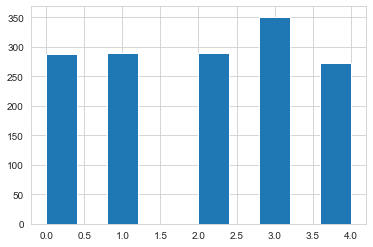

In [42]:
data['y'].hist()

In [43]:
data = data.loc[data['y'] != 4]

In [44]:
label = 'y'
positive_label = 0
protected_group = {'Gender': 1, 'Age': 1}
sensitive_vars = ['Gender', 'Age']

In [45]:
pipeline = Pipeline(steps=[
  ('scaler', StandardScaler()),
  ('classifier', LogisticRegression())
])

## Biased classifier

In [46]:
model, metrics = cross_val(pipeline, data, label, protected_group, sensitive_vars, positive_label)
print_metrics(metrics)

Statistical parity:  -0.103  +-  0.1
Disparate impact:  0.564  +-  0.267
Zero one loss:  0.124  +-  0.042
F1 score:  0.929  +-  0.021
Accuracy score:  0.929  +-  0.021


## DEMV classifier

In [47]:
demv = DEMV(round_level=1)
demv_data = data.copy()

In [48]:
model, demv_metrics = cross_val(deepcopy(pipeline), demv_data, label, protected_group, sensitive_features=sensitive_vars, debiaser=demv, positive_label=positive_label)
print_metrics(demv_metrics)

Statistical parity:  -0.101  +-  0.106
Disparate impact:  0.562  +-  0.27
Zero one loss:  0.106  +-  0.051
F1 score:  0.932  +-  0.024
Accuracy score:  0.932  +-  0.024


## DEMV Evaluation

In [49]:
iters = demv.get_iters()

In [50]:
iters

38

In [51]:
metrics = eval_demv(10, iters, data.copy(), pipeline, label, protected_group, sensitive_vars, positive_label=positive_label)

##  Blackbox Postprocessing

In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
data = data.sample(frac=1).reset_index(drop=True)

In [37]:
model, blackboxmetrics, pred = cross_val2(pipeline, data, label, protected_group, sensitive_vars, positive_label=positive_label)

(4,)
(4, 4)
(4,)
(4, 4)

Pre-adjustment group rates are 

(4,)
(4, 4)
0
      fpr  tpr
0  0.0000  1.0
1  0.0000  1.0
2  0.0000  0.9
3  0.0217  1.0

(4,)
(4, 4)
1
      fpr     tpr
0  0.0179  1.0000
1  0.0185  0.7692
2  0.0612  0.9444
3  0.0000  0.9600


And loss is 0.0492

(4,)
(4, 4)
(4,)
(4, 4)

Pre-adjustment group rates are 

(4,)
(4, 4)
0
      fpr    tpr
0  0.0000  1.000
1  0.0000  1.000
2  0.0000  0.875
3  0.0244  1.000

(4,)
(4, 4)
1
      fpr     tpr
0  0.0196  1.0000
1  0.0204  0.7500
2  0.0667  0.9375
3  0.0000  0.9565


And loss is 0.0550

[1.00000000e+00 2.02614825e-11 8.04994449e-12 3.78110584e-11]
[0.03297683 0.75       0.21177559 0.00524758]
[4.61161779e-11 8.29081637e-03 8.90018428e-01 1.01690756e-01]
[2.01314107e-10 6.63265306e-02 1.20147422e-01 8.13526048e-01]
[1.00000000e+00 2.69018264e-11 3.87247318e-11 5.32149738e-13]
[0.08333333 0.75       0.1582255  0.00844117]
[2.84308206e-11 6.25000000e-02 8.90018428e-01 4.74815724e-02]
[3.28690018e-11 1.01782126e-11 1.8647395

##  Plot

In [52]:
df = prepareplots(metrics, 'obesity')

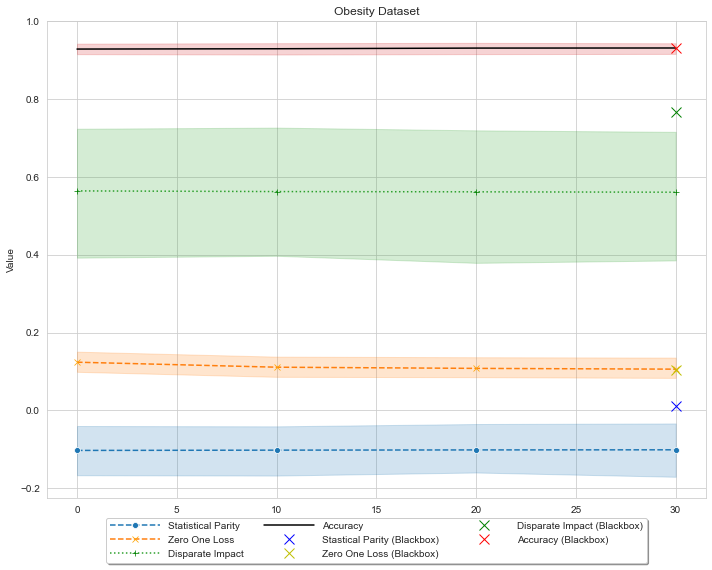

In [56]:
points = preparepoints(blackboxmetrics, 30)

plot_metrics_curves(df, points, 'Obesity Dataset')

In [54]:
unprivpergentage(data, protected_group, 52)

Dataset size: 1218
Unprivileged group size: 353
Percentage of unprivileged group: 28.981937602627255
Number of iterations: 52


In [55]:
save_metrics('blackbox', 'obesity', blackboxmetrics)